In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
rc('animation', html='jshtml')
from scipy.optimize import curve_fit
from scipy.special import erf
import uncertainties as unc
import astropy.constants as c
import hapi as hp
pd.set_option('display.max_columns', None)
from IPython.display import set_matplotlib_formats
from matplotlib.ticker import ScalarFormatter

#set_matplotlib_formats("png")
plt.rc("xtick", labelsize=16, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=16, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=16) #Font og fontstørrelse
plt.rc("figure",figsize=(14, 8),dpi=250) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # This forces scientific notation

# Set before plotting
# plt.tick_params(direction="in", top=True, right=True, labelsize=15)


/tmp/ipykernel_35869/1210214877.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


HAPI version: 1.2.2.2
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:875: SyntaxWarning: invalid escape sequence '\%'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:964: SyntaxWarning: invalid escape sequence '\%'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:991: SyntaxWarning: invalid escape sequence '\%'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:1149: SyntaxWarning: invalid escape sequence '\d'
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/hitran_api-1.2.2.2-py3.12.egg/hapi/hapi.py:1303: SyntaxWarning: invalid escape sequence '\.'
/Us

In [2]:
# First scan started 10:05 09-10-2024. The data should have to loops 
# Seems like the crystals take more than 5 minutes to warm up as stated in the manual 

In [3]:
hp.db_begin('data')

Using data

CH4
                     Lines parsed: 111966
O3
                     Lines parsed: 96632
H2O
                     Lines parsed: 23942
CO2
                     Lines parsed: 335
N2O
                     Lines parsed: 14666
O2
                     Lines parsed: 52003


In [181]:
df = pd.read_csv("wavelength_data/wavelength_scan_09_10_2024_01.dat", delimiter="\t")
df_0_1_nm_raw = pd.read_csv("wavelength_data/wavelength_0.1mm_scan_10_10_2024_speed_master_10_01.dat", delimiter="\t")
df_1_nm_raw = pd.read_csv("wavelength_data/wavelength_scan_08_10_2024_01.dat", delimiter="\t")


In [182]:
df_1_nm_raw

Set_value  Mon_value    Metex       Std
0      749.0  748.99208  0.15576  0.000000
1      746.0  746.00001  0.02538  0.002354
2      747.0  746.99998  0.13714  0.009942

Calculation to go from pump and signal to the idler, i.e. the output wavelength of the OPA stage:

$\lambda_{\text{idler}} = \left( \frac{1}{\lambda_{\text{pump}}} - \frac{1}{\lambda_{\text{signal}}} \right)^{-1}$


In [36]:
# The first line is always wrong
df_0_1_nm = df_0_1_nm_raw.drop(0).reset_index(drop=True)
# The laser turned off with E07
df_0_1_nm = df_0_1_nm.loc[df_0_1_nm["Metex"] > 0.0001]

In [100]:
lambda_pump_unc = 0.05  # nm


def wavelength_idler_w_unc(lambda_pump: float) -> (float, float):
    lambda_signal = 1064.460  # nm
    lambda_signal_unc = 0.001  # nm    
    lambda_pump_float = unc.ufloat(lambda_pump, lambda_pump_unc)
    lambda_signal_float = unc.ufloat(lambda_signal, lambda_signal_unc)
    
    lambda_idler = (1 / lambda_pump_float - 1 / lambda_signal_float)**(-1)
    return lambda_idler.n, lambda_idler.s


def energy_to_photons(energy_per_wavelength, wavelengths):
    """
    Convert energy per wavelength to number of photons per wavelength.
    
    Parameters:
    - energy_per_wavelength: Array of energies at each wavelength (Joules).
    - wavelengths: Array of wavelengths (in nm).
    
    Returns:
    - photons_per_wavelength: Array of number of photons per wavelength.
    """
    photon_energy = c.h.value * c.c.value / (wavelengths * 1e-9)
    photons_per_wavelength = energy_per_wavelength / photon_energy
    return photons_per_wavelength


def wavelength_idler(lambda_pump: float) -> float:
    lambda_signal = 1064.00  # nm
    lambda_signal_unc = 0.001  # nm
    
    lambda_pump_float = unc.ufloat(lambda_pump, lambda_pump_unc)
    lambda_signal_float = unc.ufloat(lambda_signal, lambda_signal_unc)
    
    lambda_idler = (1 / lambda_pump_float - 1 / lambda_signal_float)**(-1)
    return lambda_idler


def mid_ir_to_near_ir(lambda_idler: float) -> float:
    lambda_signal = 1064.00  # nm
    
    lambda_pump = (1 / lambda_signal + 1 / lambda_idler)**(-1)
    return lambda_pump

def wavenumber_to_wavelength(wavenumber: float) -> float:
    return 1 / wavenumber * 1e7

def wavelength_to_wavenumber(wavelength: float) -> float:
    return 1 / wavelength * 1e7

#### Flash lamp discharges 
    09/10 - 2024: 010853300

In [7]:
start_wavenumber = int(wavelength_to_wavenumber(4200))
end_wavenumber = int(wavelength_to_wavenumber(2100))

# put hp. infront if you need to use it
# hp.describeTable('N2O')
# fetch('H2O',1,1, start_wavenumber, end_wavenumber)
# fetch('CO2',2,1, start_wavenumber, end_wavenumber)
# fetch('O3',3,1, start_wavenumber, end_wavenumber)
# fetch('O2',7,1, start_wavenumber, end_wavenumber) Missing this one, Update there is no data for this range for O2
# fetch('CH4',6,1, start_wavenumber, end_wavenumber)
# fetch('N2O',4,1, start_wavenumber, end_wavenumber)

In [8]:
joule_to_ev = 6.24150907 * 1e18
water_vib_wavelengths = [1/val * 1e7 for val in [3657, 1595, 3756] ] # first list in 1/cm the final is nm
water_vib_naming = [r"A_$1$ sym stretch", r"A_$1$ bend", r"B_$1$ anti stretch"]
water_vib_energies = [c.h.value * c.c.value / (w * 1e-9) * joule_to_ev for w in water_vib_wavelengths]
water_colors = ["yellow", "red", "blue"]

In [77]:
near_ir_offset = 0.1  # nm
def create_full_df(df_insert: pd.DataFrame) -> pd.DataFrame:
    df_temp = df_insert.copy()
    df_temp["Metex"] = df_temp["Metex"] * 100
    df_temp["Std"] = df_temp["Std"] * 100
    df_temp["Power"] = df_temp.apply(lambda row: unc.ufloat(row["Metex"], row["Std"]), axis=1)
    
    df_temp["Mon_value_offset"] = df_temp["Mon_value"] + near_ir_offset
    df_temp["MonWavelengthMidIR"] = df_temp["Mon_value"].apply(lambda x: wavelength_idler(x))
    df_temp["MonWavelengthMidIR_offset"] = df_temp["Mon_value_offset"].apply(lambda x: wavelength_idler(x))
    df_temp["Power in J"] = df_temp["Power"].values / 10 / 1000
    df_temp["N_Photons"] = df_temp.apply(
        lambda row: energy_to_photons(
            row["Power in J"]                            
            # Dividing with 10 to get this to be in J, since the frequency of the laser is 10 Hz
            , row["MonWavelengthMidIR"]
        ), axis=1
    )
    return df_temp

In [98]:
df_0_1_nm_tot = create_full_df(df_0_1_nm)

In [79]:
# Extra sortation of the data to delete the 846 measurement since it is missing at the end
# Also adding columns with the unc.ufloat types 
df_temp = df.loc[df["Set_value"] != 846].copy()
df_tot = create_full_df(df_temp)

In [80]:
mean_wavelength = (df_tot.query("index < 100")["MonWavelengthMidIR"].values + 
                         df_tot.query("index >= 100")["MonWavelengthMidIR"].values) / 2

mean_wavelength_offset = (df_tot.query("index < 100")["MonWavelengthMidIR_offset"].values + 
                          df_tot.query("index >= 100")["MonWavelengthMidIR_offset"].values) / 2

difference_power = (df_tot.query("index < 100")["Power"].values - 
                         df_tot.query("index >= 100")["Power"].values)

mean_power = (df_tot.query("index < 100")["Power"].values + 
                         df_tot.query("index >= 100")["Power"].values) / 2


In [81]:
difference_photon = (df_tot.query("index < 100")["N_Photons"].values - 
                         df_tot.query("index >= 100")["N_Photons"].values)

mean_photon = (df_tot.query("index < 100")["N_Photons"].values + 
                         df_tot.query("index >= 100")["N_Photons"].values) / 2

mean_wavelengths_near = (df_tot.query("index < 100")["Mon_value"].values + 
                         df_tot.query("index >= 100")["Mon_value"].values) / 2

mean_xs = [x.n for x in mean_wavelength]


In [191]:
xs_to_use = [wavelength_to_wavenumber(x) for x in xs]  # change xs to fit with df

def get_absorption_data(molecule: str):
    
    nu, coef = hp.absorptionCoefficient_Lorentz(SourceTables=molecule, 
                                                Diluent={'air': 1.0}, 
                                                Environment = {'p': 1.0,'T': 296.0}, 
                                                HITRAN_units=False,
                                                WavenumberGrid=xs_to_use,
                                               )
    nu_new, absorp = hp.absorptionSpectrum(nu, coef, # The Temperature here needs to be the same as in the one before
                                           Environment={'T': 296.0, 'l': 100.0},
                                          )

    assert len(nu_new) == len(xs_to_use), "Mismatch between wavenumber grid and absorption data length!"
    assert len(nu_new) == len(absorp), "Mismatch between wavenumber grid and absorption data length!"

    return nu_new, absorp

In [192]:
# nu is in 1 / cm 
nu_n2o, absorp_n2o = get_absorption_data("N2O")
nu_ch4, absorp_ch4 = get_absorption_data("CH4")
nu_h2o, absorp_h2o = get_absorption_data("H2O")
nu_o3, absorb_o3 = get_absorption_data("O3")
nu_co2, absorb_co2 = get_absorption_data("CO2")

{'air': 1.0}
1.652560 seconds elapsed for abscoef; nlines = 14666
{'air': 1.0}
9.260737 seconds elapsed for abscoef; nlines = 111966
{'air': 1.0}
2.692903 seconds elapsed for abscoef; nlines = 23942
{'air': 1.0}
6.396244 seconds elapsed for abscoef; nlines = 96632
{'air': 1.0}
0.037927 seconds elapsed for abscoef; nlines = 335


In [18]:
# These values will be used for the uncertainties regarding the divergense measurements
print(f"Uncertainties used for the divergense measurements:")
print()
print(r"Power Range [mW] │ Max Uncertainty Times 2 [mW]")
for i in range(0, 35, 5):
    max_val = max([i.s for i in df_tot.query(f"Metex > {i} & Metex <= {i + 5}")["Power"]])
    if i == 0:
        extra = "  "
    elif i == 5:
        extra = " "
    else:
        extra = ""
    print(f"{i} - {i + 5}        {extra}  │ {max_val * 2:.2f}")


Uncertainties used for the divergense measurements:

Power Range [mW] │ Max Uncertainty Times 2 [mW]
0 - 5            │ 1.41
5 - 10           │ 2.85
10 - 15          │ 4.07
15 - 20          │ 7.22
20 - 25          │ 5.37
25 - 30          │ 5.28
30 - 35          │ 5.95


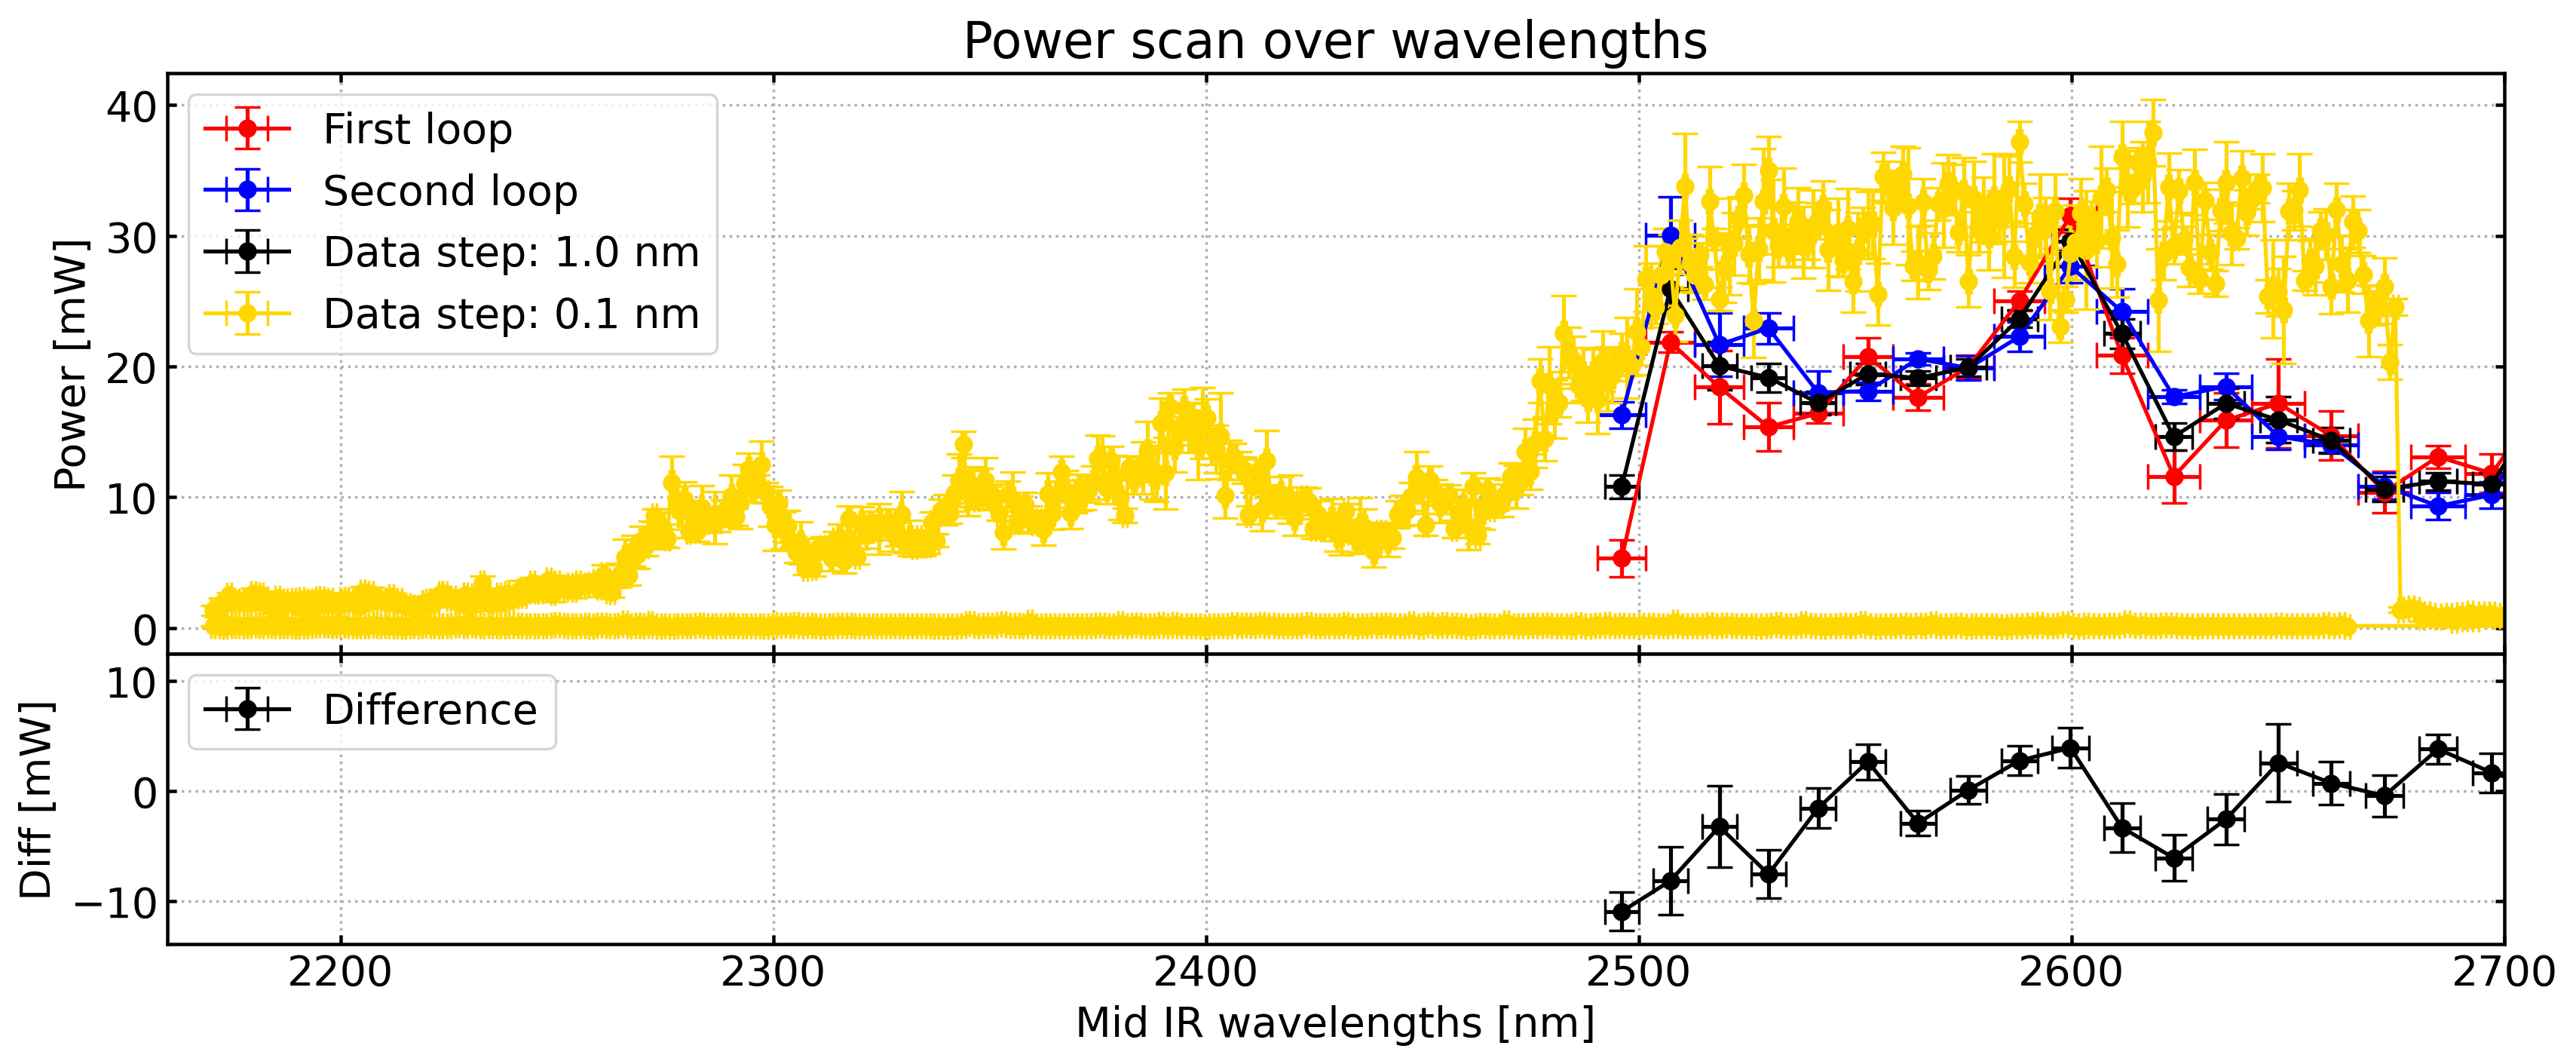

In [116]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, 
                        gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]}, figsize=(16,6))



ax = axs[0]
df = df_tot.query("index < 100").copy()
xs = [x.n for x in df["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df["MonWavelengthMidIR"]]
ys = [y.n for y in df["Power"]]
ys_unc = [y.s for y in df["Power"]]

ax.errorbar(xs, ys, 
            yerr=ys_unc, xerr=xs_unc, fmt='o-', 
            label='First loop', 
            color='red', capsize=5)

df = df_tot.query("index >= 100").copy()
xs = [x.n for x in df["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df["MonWavelengthMidIR"]]
ys = [y.n for y in df["Power"]]
ys_unc = [y.s for y in df["Power"]]

ax.errorbar(xs, ys, 
            yerr=ys_unc, xerr=xs_unc, fmt='o-', 
            label='Second loop', 
            color='blue', capsize=5)

ax.set_ylabel("Power [mW]")
ax.set_title("Power scan over wavelengths")

xs = [x.n for x in mean_wavelength]
xs_unc = [x.s for x in mean_wavelength]
ys = [y.n for y in mean_power]
ys_unc = [y.s for y in mean_power]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data step: 1.0 nm', color='black', capsize=5)

xs = [x.n for x in df_0_1_nm_tot["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df_0_1_nm_tot["MonWavelengthMidIR"]]
ys = [y.n for y in df_0_1_nm_tot["Power"]]
ys_unc = [y.s for y in df_0_1_nm_tot["Power"]]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data step: 0.1 nm', color='gold', capsize=5)

xlims = [2160, 2700]

ax.set_xlim(xlims)
ax.legend()

ax = axs[1]
ax.set_xlim(xlims)

xs = [x.n for x in mean_wavelength]
xs_unc = [x.s for x in mean_wavelength]
ys = [y.n for y in difference_power]
ys_unc = [y.s for y in difference_power]

ax.errorbar(xs, ys, 
            yerr=ys_unc, xerr=xs_unc, fmt='o-', 
            label='Difference', 
            color='black', capsize=5)

ax.set_ylabel("Diff [mW]")
ax.set_xlabel("Mid IR wavelengths [nm]")
ax.legend()

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Skal omdannes til antal photoner 

In [23]:
max_wavelength = max([i.n for i in df_tot["MonWavelengthMidIR"]])
min_wavelength = min([i.n for i in df_tot["MonWavelengthMidIR"]])

# in nm
wavelengths_nir = np.linspace(715, 880, 10000)
wavelengths = np.array([wavelength_idler(x).n for x in wavelengths_nir])
# in eV
photon_energies = c.h.value * c.c.value / (wavelengths * 1e-9) * joule_to_ev 

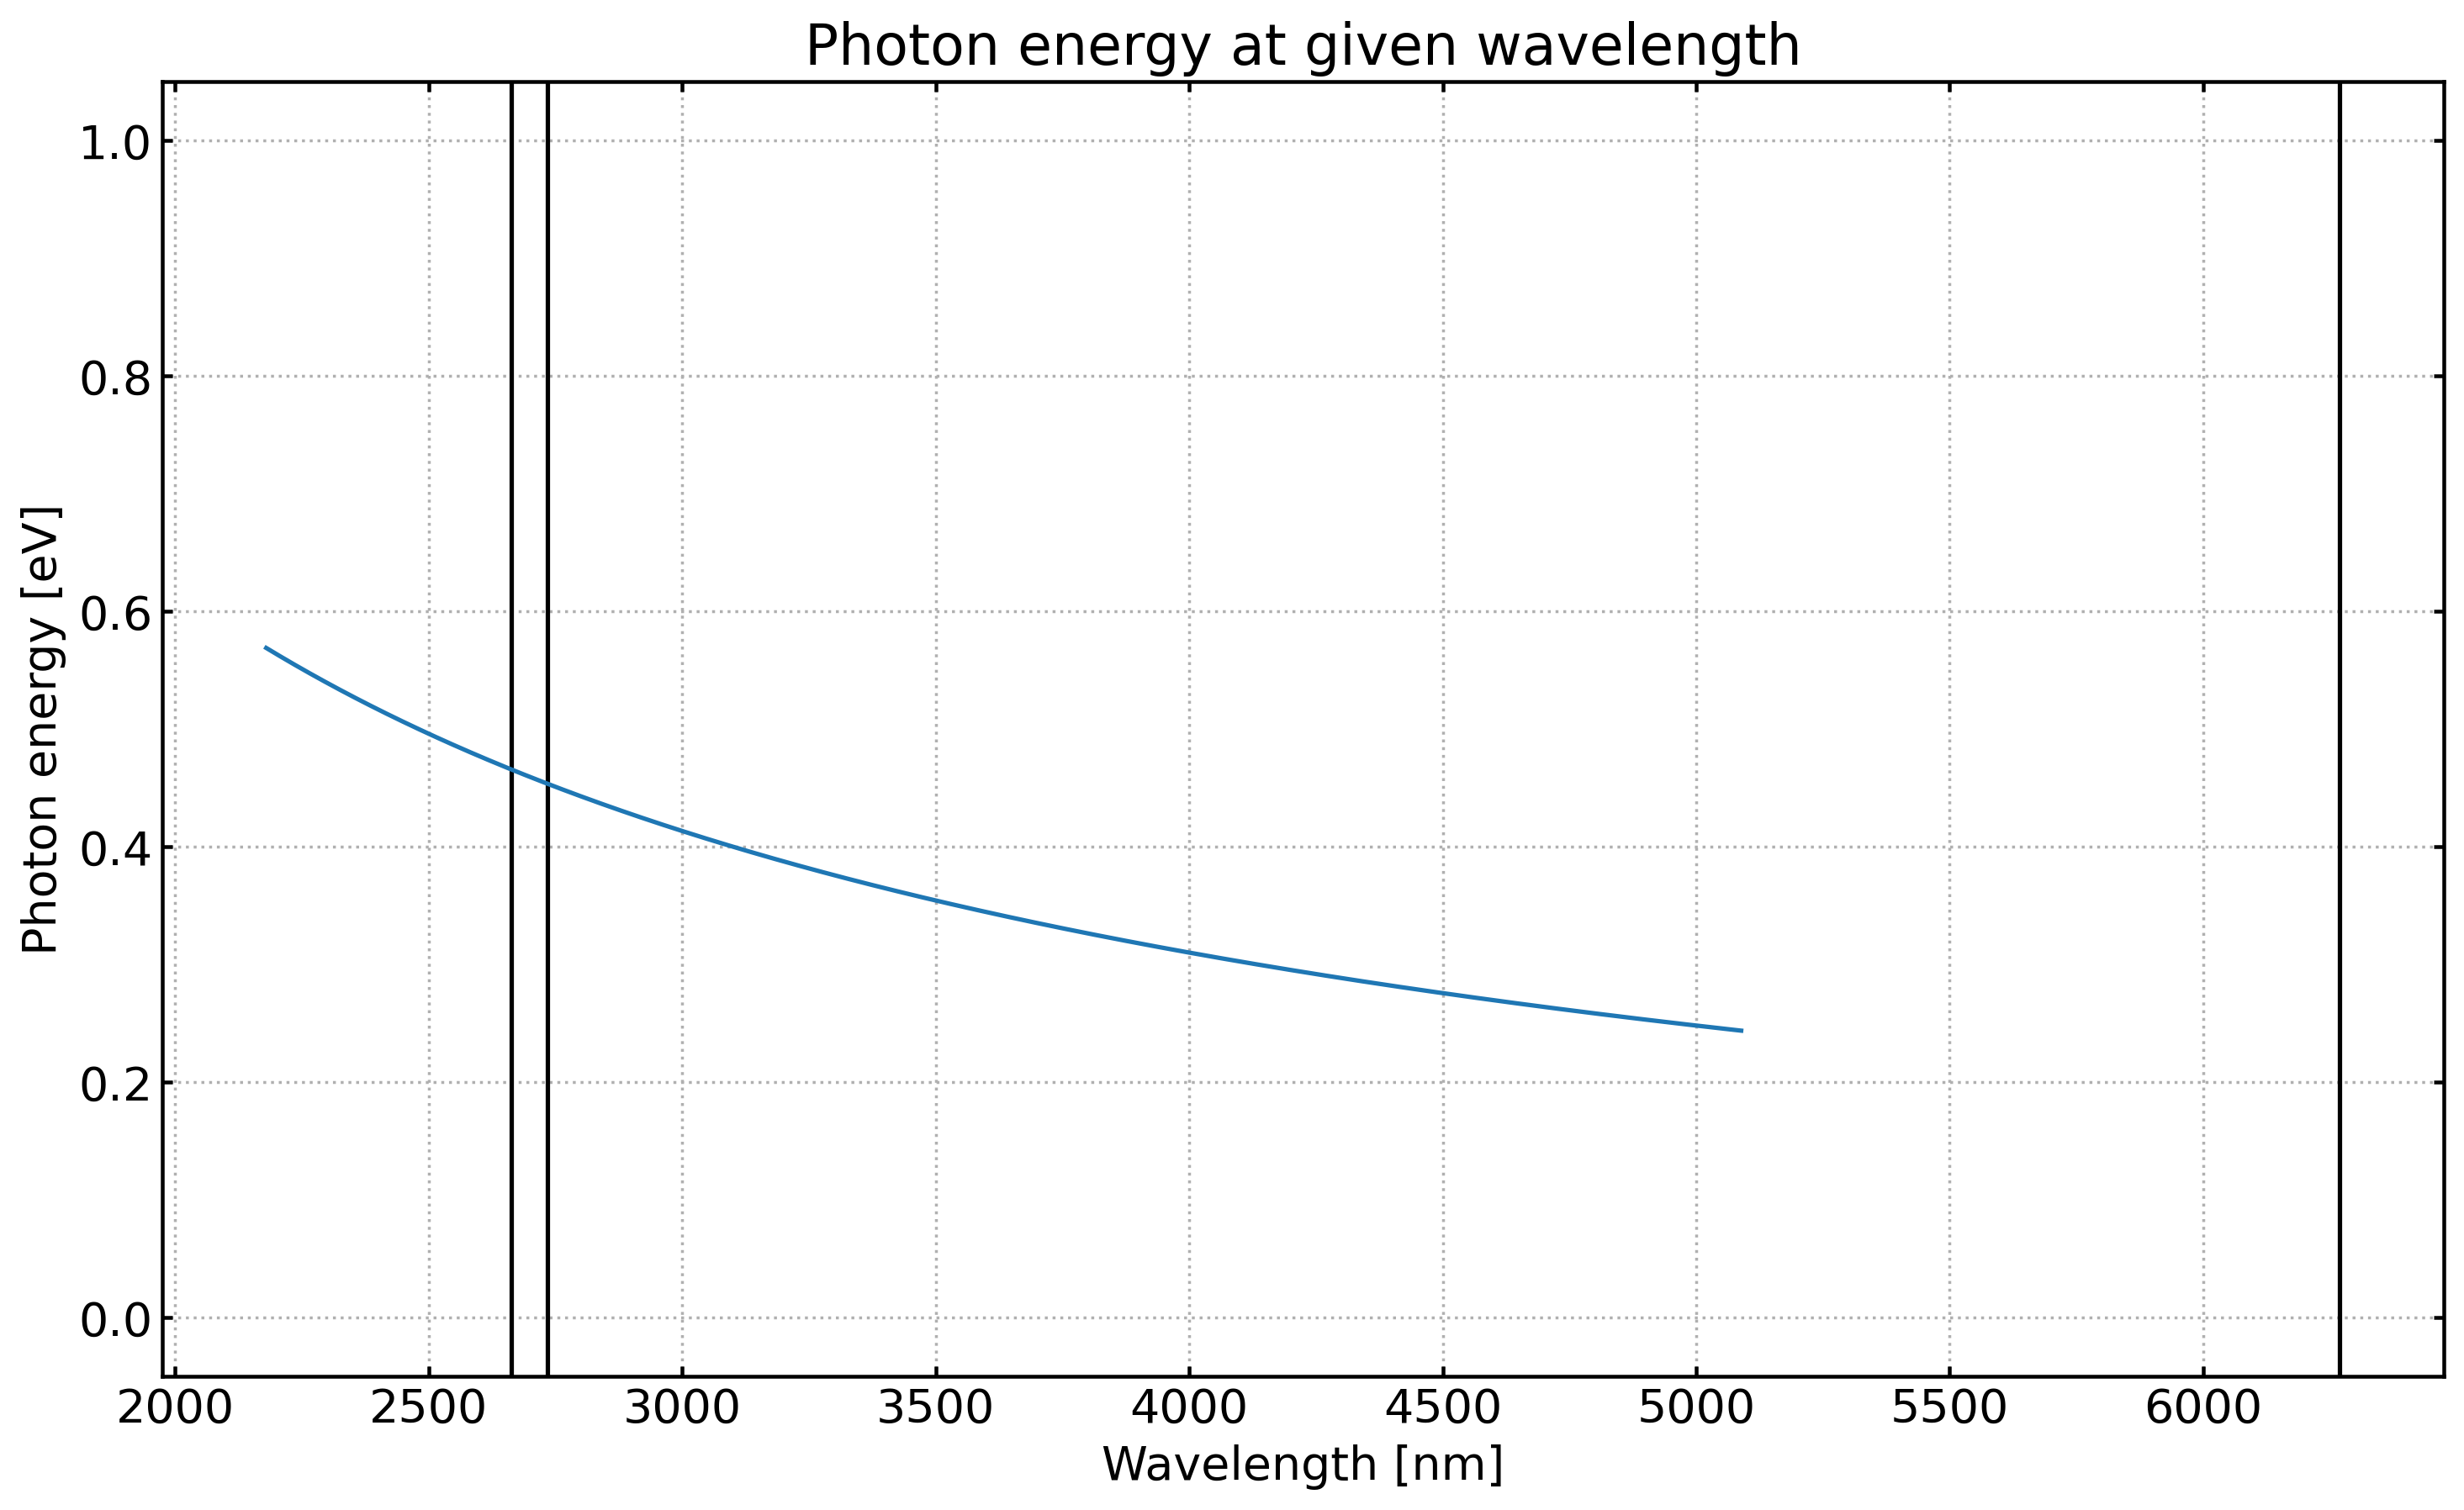

(2179.828080229226, 5088.695652173913)

In [24]:
for i in range(len(water_vib_wavelengths)):
    plt.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 1),
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", color="black")
plt.plot(wavelengths, photon_energies)
plt.ylabel("Photon energy [eV]")
plt.xlabel("Wavelength [nm]")
plt.title("Photon energy at given wavelength")
plt.show()
wavelengths[0], wavelengths[-1]

In [46]:
df_0_1_nm_tot.query(f"Mon_value > {mid_ir_to_near_ir(2675)}")


index  Set_value  Mon_value  Metex     Std          Power  \
473     474      761.3  761.29999  1.380  0.2063    1.38+/-0.21   
474     475      761.4  761.39996  1.394  0.1728    1.39+/-0.17   
475     476      761.5  761.49997  1.533  0.2806    1.53+/-0.28   
476     477      761.6  761.59999  1.423  0.1700    1.42+/-0.17   
477     478      761.7  761.69997  0.770  0.2658    0.77+/-0.27   
...     ...        ...        ...    ...     ...            ...   
1316   1317      845.6  845.59997  0.148  0.0434    0.15+/-0.04   
1317   1318      845.7  845.69994  0.130  0.0149  0.130+/-0.015   
1318   1319      845.8  845.79997  0.158  0.0671    0.16+/-0.07   
1319   1320      845.9  845.89996  0.216  0.0657    0.22+/-0.07   
1320   1321      846.0  845.99998  0.163  0.0442    0.16+/-0.04   

      Mon_value_offset MonWavelengthMidIR MonWavelengthMidIR_offset  \
473          764.79999           2676+/-6                  2720+/-6   
474          764.89996           2677+/-6                  2721+/-6   
475          764.99997           2678+/-6                  2722+/-6   
476          765.09999           2680+/-6                  2724+/-6   
477          765.19997           2681+/-6                  2725+/-6   
...                ...                ...                       ...   
1316         849.09997          4120+/-12                 4204+/-12   
1317         849.19994          4122+/-12                 4206+/-12   
1318         849.29997          4124+/-12                 4209+/-12   
1319         849.39996          4127+/-12                 4211+/-12   
1320         849.49998          4129+/-12                 4214+/-12   

               Power in J          N_Photons  
473   0.000138+/-0.000021  (1.86+/-0.28)e+15  
474   0.000139+/-0.000017  (1.88+/-0.23)e+15  
475   0.000153+/-0.000028    (2.1+/-0.4)e+15  
476   0.000142+/-0.000017  (1.92+/-0.23)e+15  
477       (7.7+/-2.7)e-05    (1.0+/-0.4)e+15  
...                   ...                ...  
1316      (1.5+/-0.4)e-05    (3.1+/-0.9)e+14  
1317    (1.30+/-0.15)e-05  (2.70+/-0.31)e+14  
1318      (1.6+/-0.7)e-05    (3.3+/-1.4)e+14  
1319      (2.2+/-0.7)e-05    (4.5+/-1.4)e+14  
1320      (1.6+/-0.4)e-05    (3.4+/-0.9)e+14  

[848 rows x 11 columns]

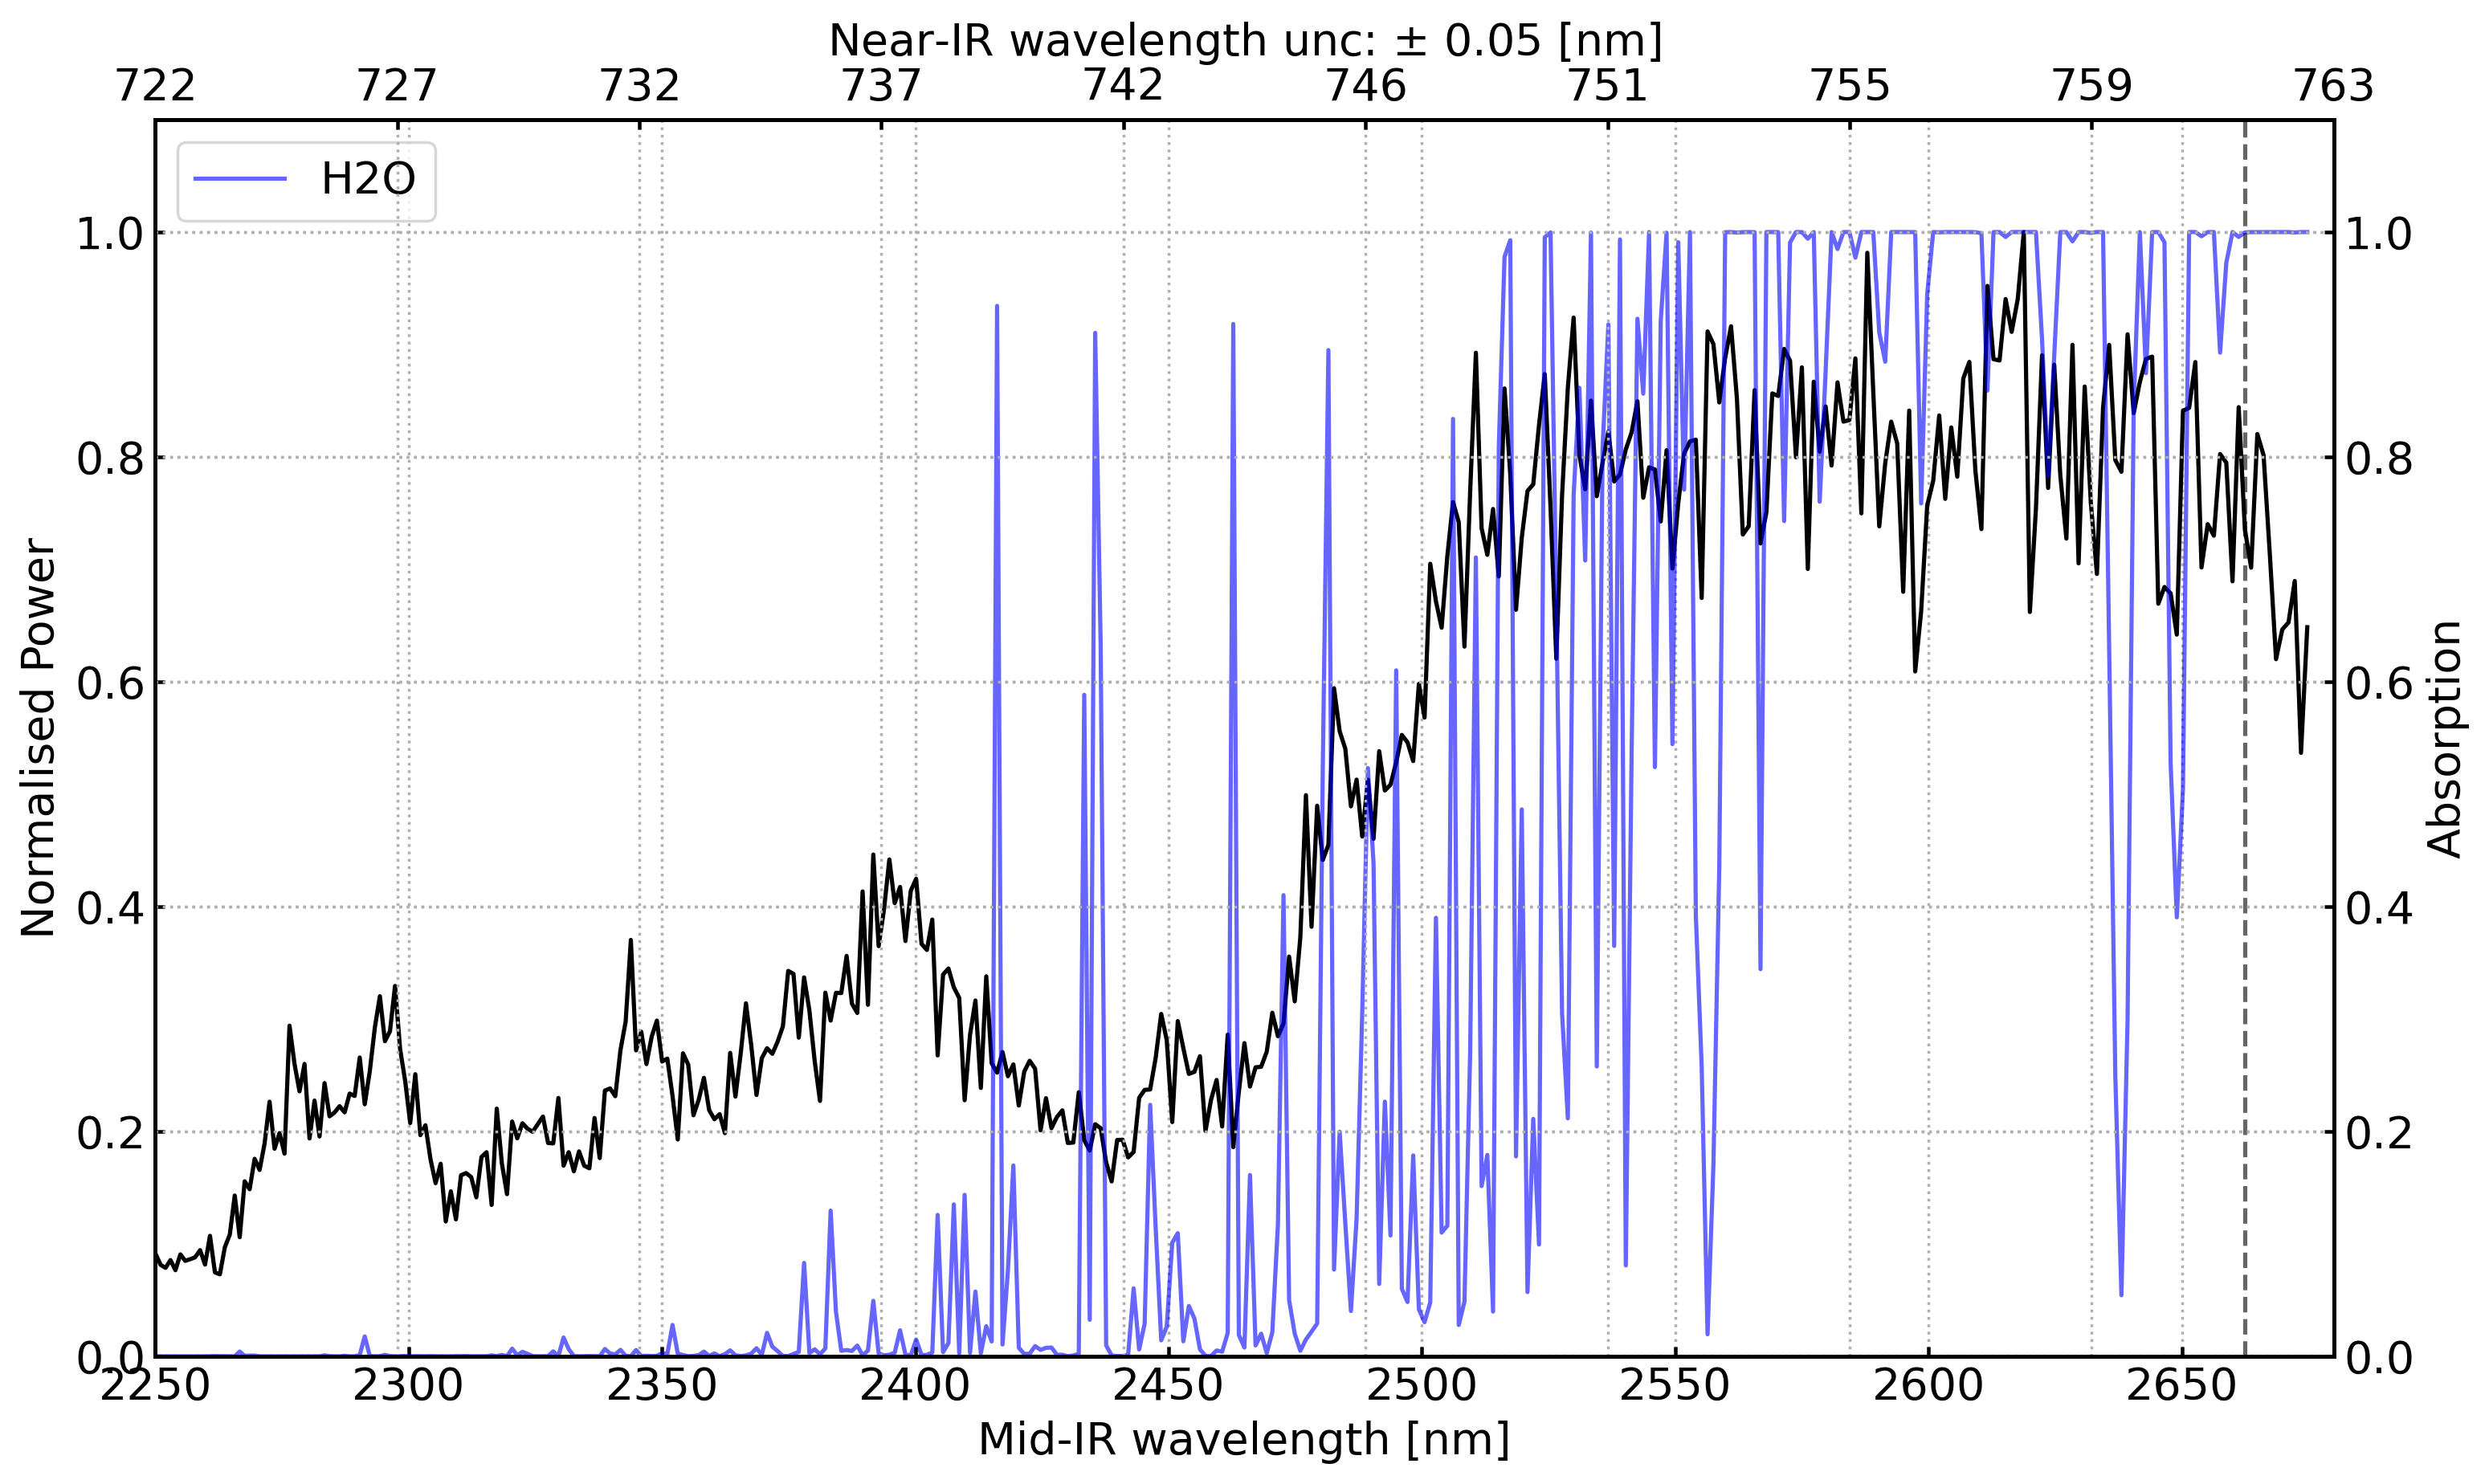

(37.885000000000005, 1.202)

In [197]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False)
                        #gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]})
df_0_1_nm_sub = df_0_1_nm_tot.loc[df_0_1_nm_tot.index < 473]
line = True
fill = False
for i in range(len(water_vib_wavelengths)):
    if i == 1:
        continue
    if line:
        ax.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 5e16),
              # label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color="black", alpha=0.6, linestyle="--"
                    )
    if fill:
        ax.fill_betweenx([0, 5e16], water_vib_wavelengths[i] - 10, water_vib_wavelengths[i] + 10,
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color=water_colors[i], alpha=0.6
                    )

ax.set_ylabel("Normalised Power")
ax.set_xlabel("Mid-IR wavelength [nm]")

# mean_xs done before to be used for the absorption_spectrum
xs_unc = [x.s for x in mean_wavelength]
ys = [y.n for y in mean_photon]
ys_unc = [y.s for y in mean_photon]

# ax.errorbar(mean_xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data', color='Black', capsize=5)


xs = [x.n for x in df_0_1_nm_sub["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df_0_1_nm_sub["MonWavelengthMidIR"]]
ys = [y.n for y in df_0_1_nm_sub["Power"]]
ys_unc = [y.s for y in df_0_1_nm_sub["Power"]]

ax.plot(xs, np.array(ys) / max(ys), color="black")#, yerr=np.array(ys_unc) / max(ys), xerr=xs_unc,
           # fmt='o-', label='Data step: 0.1 nm', color='black', capsize=5)

offset = 0.1
ylims = [0, 1 + offset]
ax.set_ylim(ylims)



ax2 = ax.twiny()


ax3 = ax.twinx()

ax3.set_yticks(ax.get_yticks()) 
ax3.set_ylim(ylims)
ax3.set_yticklabels([f"{y_tick:.1f}" for y_tick in np.linspace(0, 1.2, len(ax.get_yticks()))])
ax3.set_ylabel('Absorption', color='Black')
ax3.tick_params(axis='y', labelcolor='Black')

# Apply the formatter to the y-axis
# ax.yaxis.set_major_formatter(formatter)
# ax.set_yticks(np.arange(0, 6e16, 1e16))
# ax.set_yticklabels([f'{int(tick/1e16)}' + r'$\cdot 10^{16}$' if tick!=0 else '0' for tick in ax.get_yticks()])

norm_factor = (ylims[-1] - offset)
ax.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o * norm_factor, label="H2O", alpha=0.6, color="Blue")
# ax.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3 * norm_factor, label="O3", alpha=0.6, color="silver")
# ax.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2 * norm_factor, label="CO2", alpha=0.6, color="black")
# ax.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4 * norm_factor, label="CH4", alpha=0.6, color="green")
# ax.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o * norm_factor, label="N2O", alpha=0.6, color="Purple")

x_lims = [2250, 2680]
ax2.set_xlim(x_lims)
ax.set_xlim(x_lims)

ax2.set_xticks(ax.get_xticks()) 
ax2.set_xticklabels([f"{round(mid_ir_to_near_ir(x_tick), 0):.0f}" for x_tick in ax.get_xticks()])
ax2.set_xlabel(r'Near-IR wavelength unc: $\pm$' + f' {lambda_pump_unc} [nm]', color='Black')
ax2.tick_params(axis='x', labelcolor='Black')

ax.legend()
plt.show()
max(ys), min(ys) 

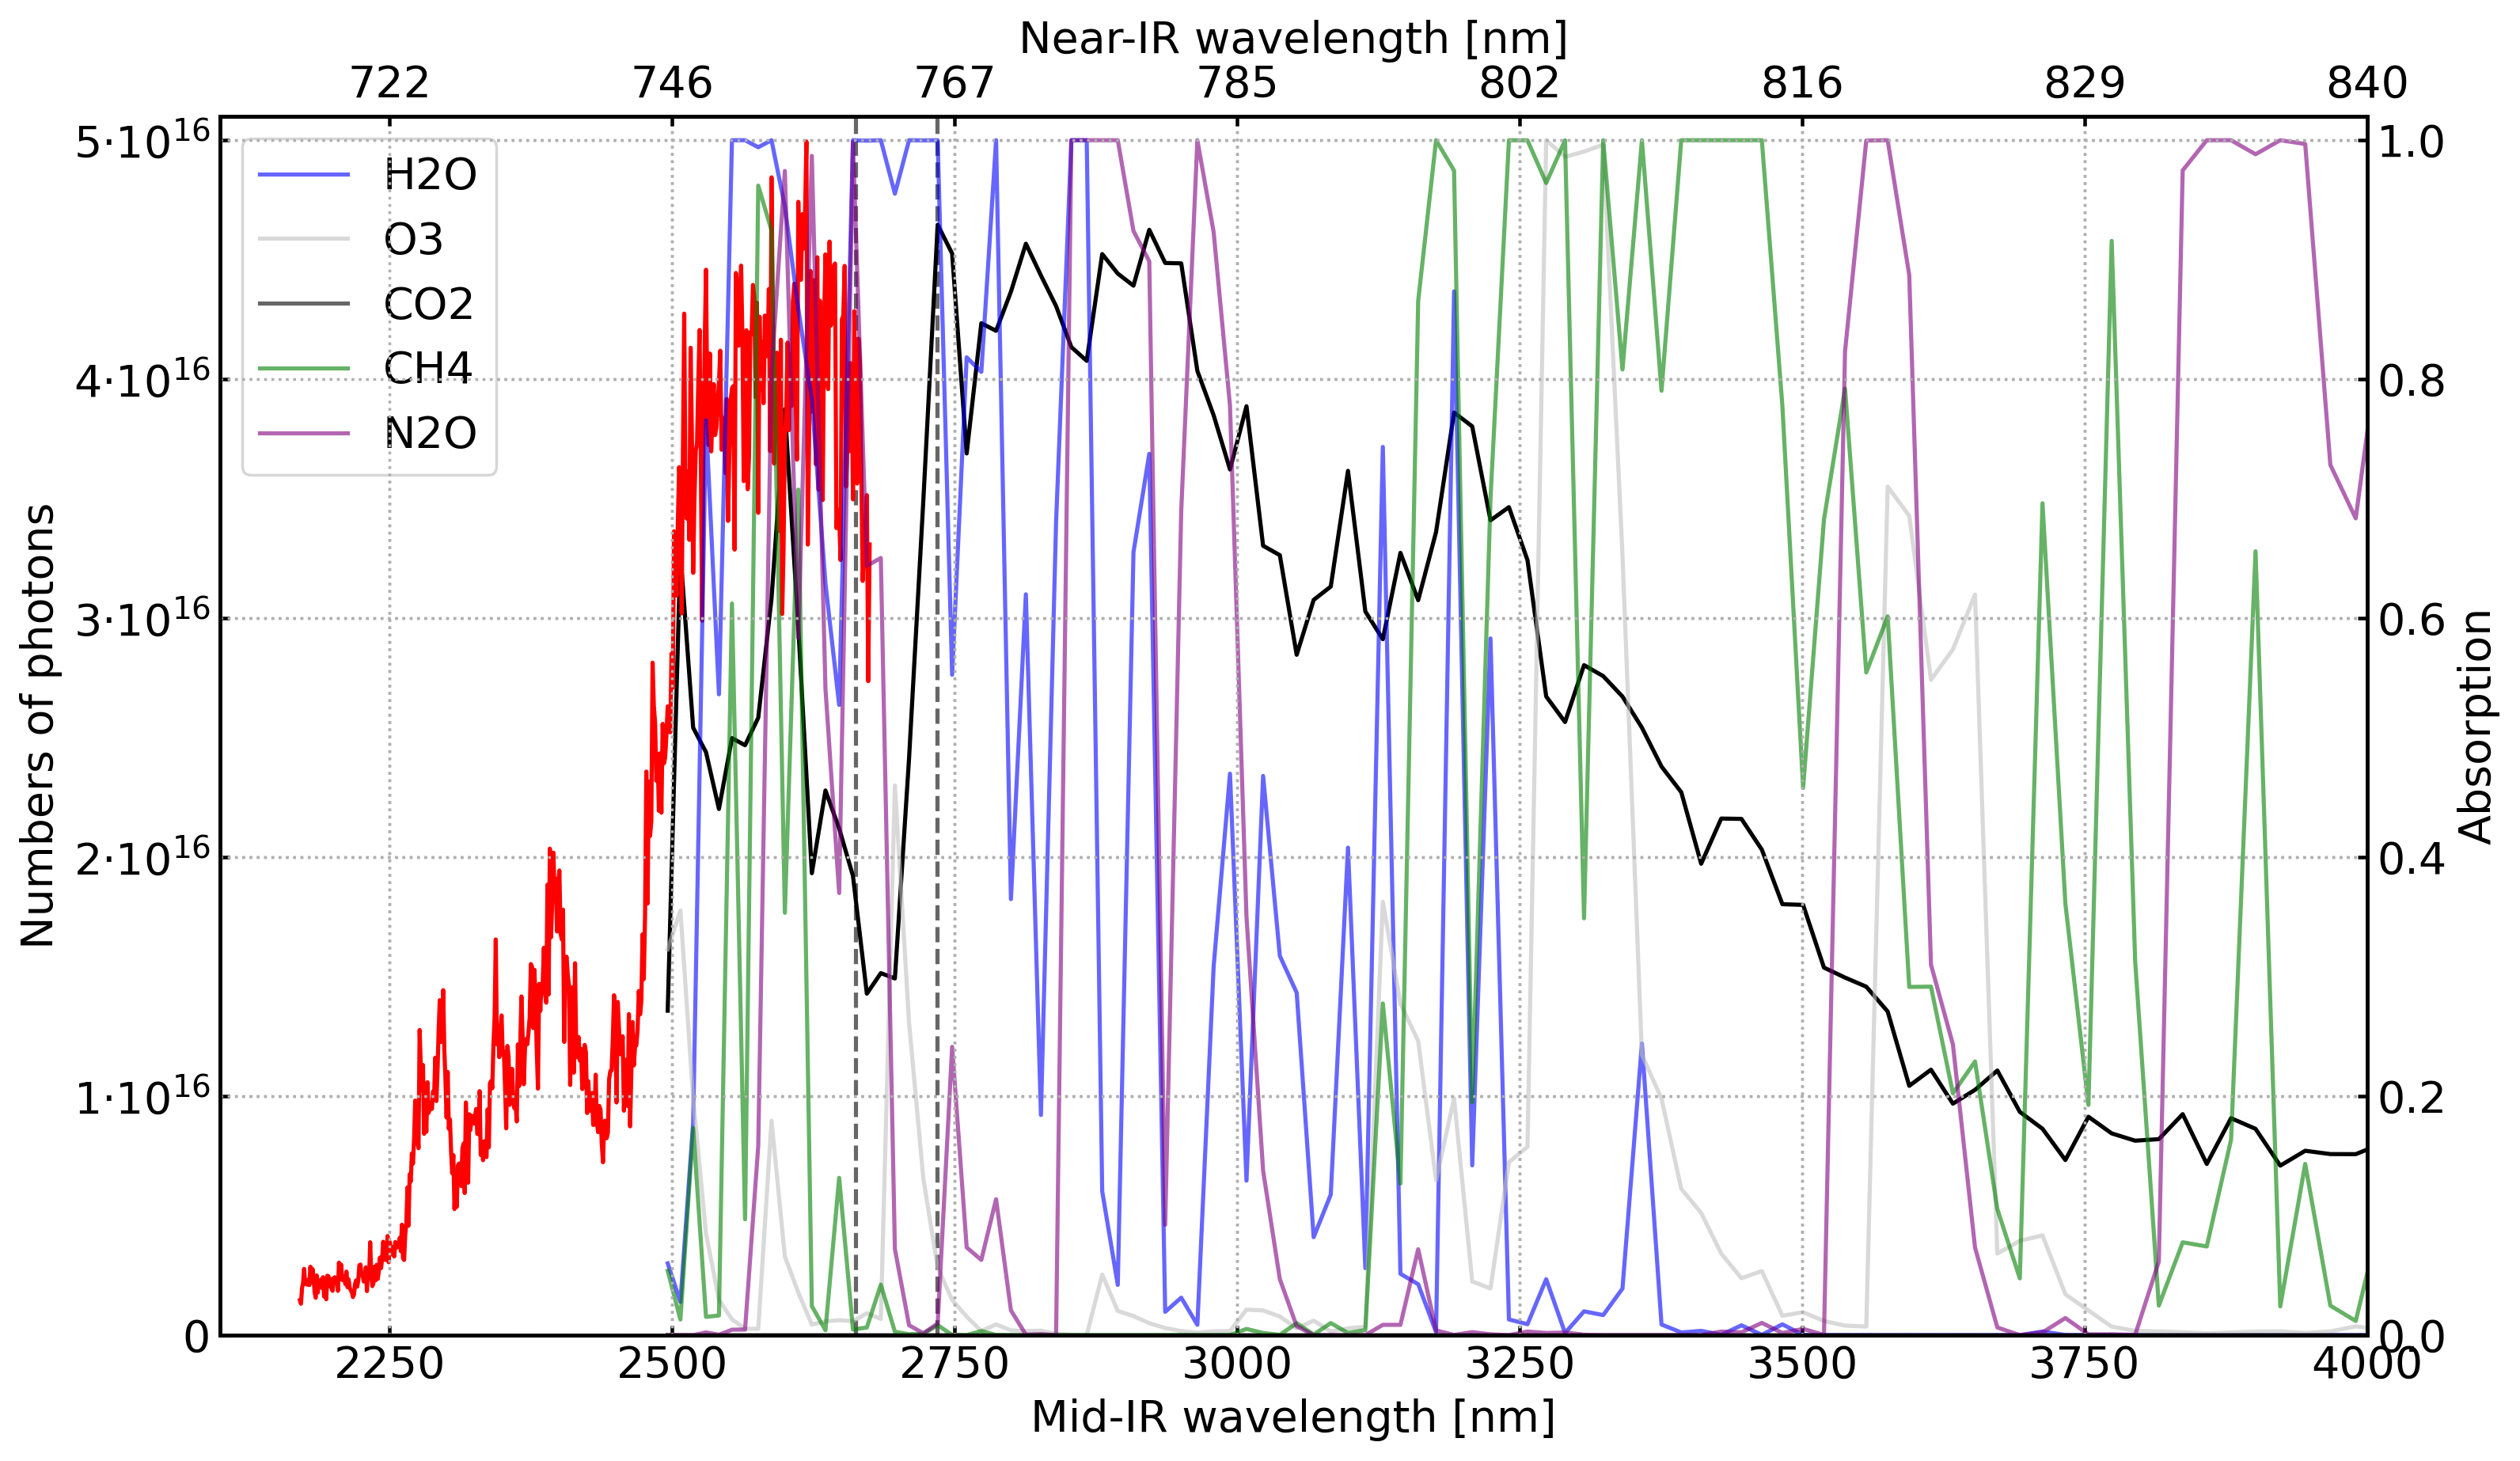

In [188]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False)
                        #gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]})
line = True
fill = False
for i in range(len(water_vib_wavelengths)):
    if i == 1:
        continue
    if line:
        ax.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 5e16),
              # label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color="black", alpha=0.6, linestyle="--"
                    )
    if fill:
        ax.fill_betweenx([0, 5e16], water_vib_wavelengths[i] - 10, water_vib_wavelengths[i] + 10,
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color=water_colors[i], alpha=0.6
                    )

ax.set_ylabel("Numbers of photons")
ax.set_xlabel("Mid-IR wavelength [nm]")

# mean_xs done before to be used for the absorption_spectrum
xs_unc = [x.s for x in mean_wavelength]
ys = [y.n for y in mean_photon]
ys_unc = [y.s for y in mean_photon]

ax.plot(mean_xs, ys, color="black")#, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data', color='Black', capsize=5)


xs = [x.n for x in df_0_1_nm_sub["MonWavelengthMidIR"]]
xs_unc = [x.s for x in df_0_1_nm_sub["MonWavelengthMidIR"]]
ys = [y.n for y in df_0_1_nm_sub["N_Photons"]]
ys_unc = [y.s for y in df_0_1_nm_sub["N_Photons"]]

ax.plot(xs, ys, color="red")#, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data step: 0.1 nm', color='red', capsize=5)

ax.set_ylim(0, 5.1e16)
xlims = [2100, 4000]
ax.set_xlim(xlims)


ax2 = ax.twiny()

ax2.set_xticks(ax.get_xticks()) 
ax2.set_xlim(xlims)
ax2.set_xticklabels([f"{round(mid_ir_to_near_ir(x_tick), 0):.0f}" for x_tick in ax.get_xticks()])
ax2.set_xlabel(f'Near-IR wavelength [nm]', color='Black')
ax2.tick_params(axis='x', labelcolor='Black')

ax2 = ax.twinx()

ax2.set_yticks(ax.get_yticks()) 
ax2.set_ylim(0, 5.1e16)
ax2.set_yticklabels([f"{y_tick:.1f}" for y_tick in np.linspace(0, 1.2, len(ax.get_yticks()))])
ax2.set_ylabel('Absorption', color='Black')
ax2.tick_params(axis='y', labelcolor='Black')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)
ax.set_yticks(np.arange(0, 6e16, 1e16))
ax.set_yticklabels([f'{int(tick/1e16)}' + r'$\cdot 10^{16}$' if tick!=0 else '0' for tick in ax.get_yticks()])

ax.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o * 5e16, label="H2O", alpha=0.6, color="Blue")
ax.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3 * 5e16, label="O3", alpha=0.6, color="silver")
ax.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2 * 5e16, label="CO2", alpha=0.6, color="black")
ax.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4 * 5e16, label="CH4", alpha=0.6, color="green")
ax.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o * 5e16, label="N2O", alpha=0.6, color="Purple")

ax.legend()
plt.show()


In [152]:
absorp_h2o[200]

0.049848084685699456

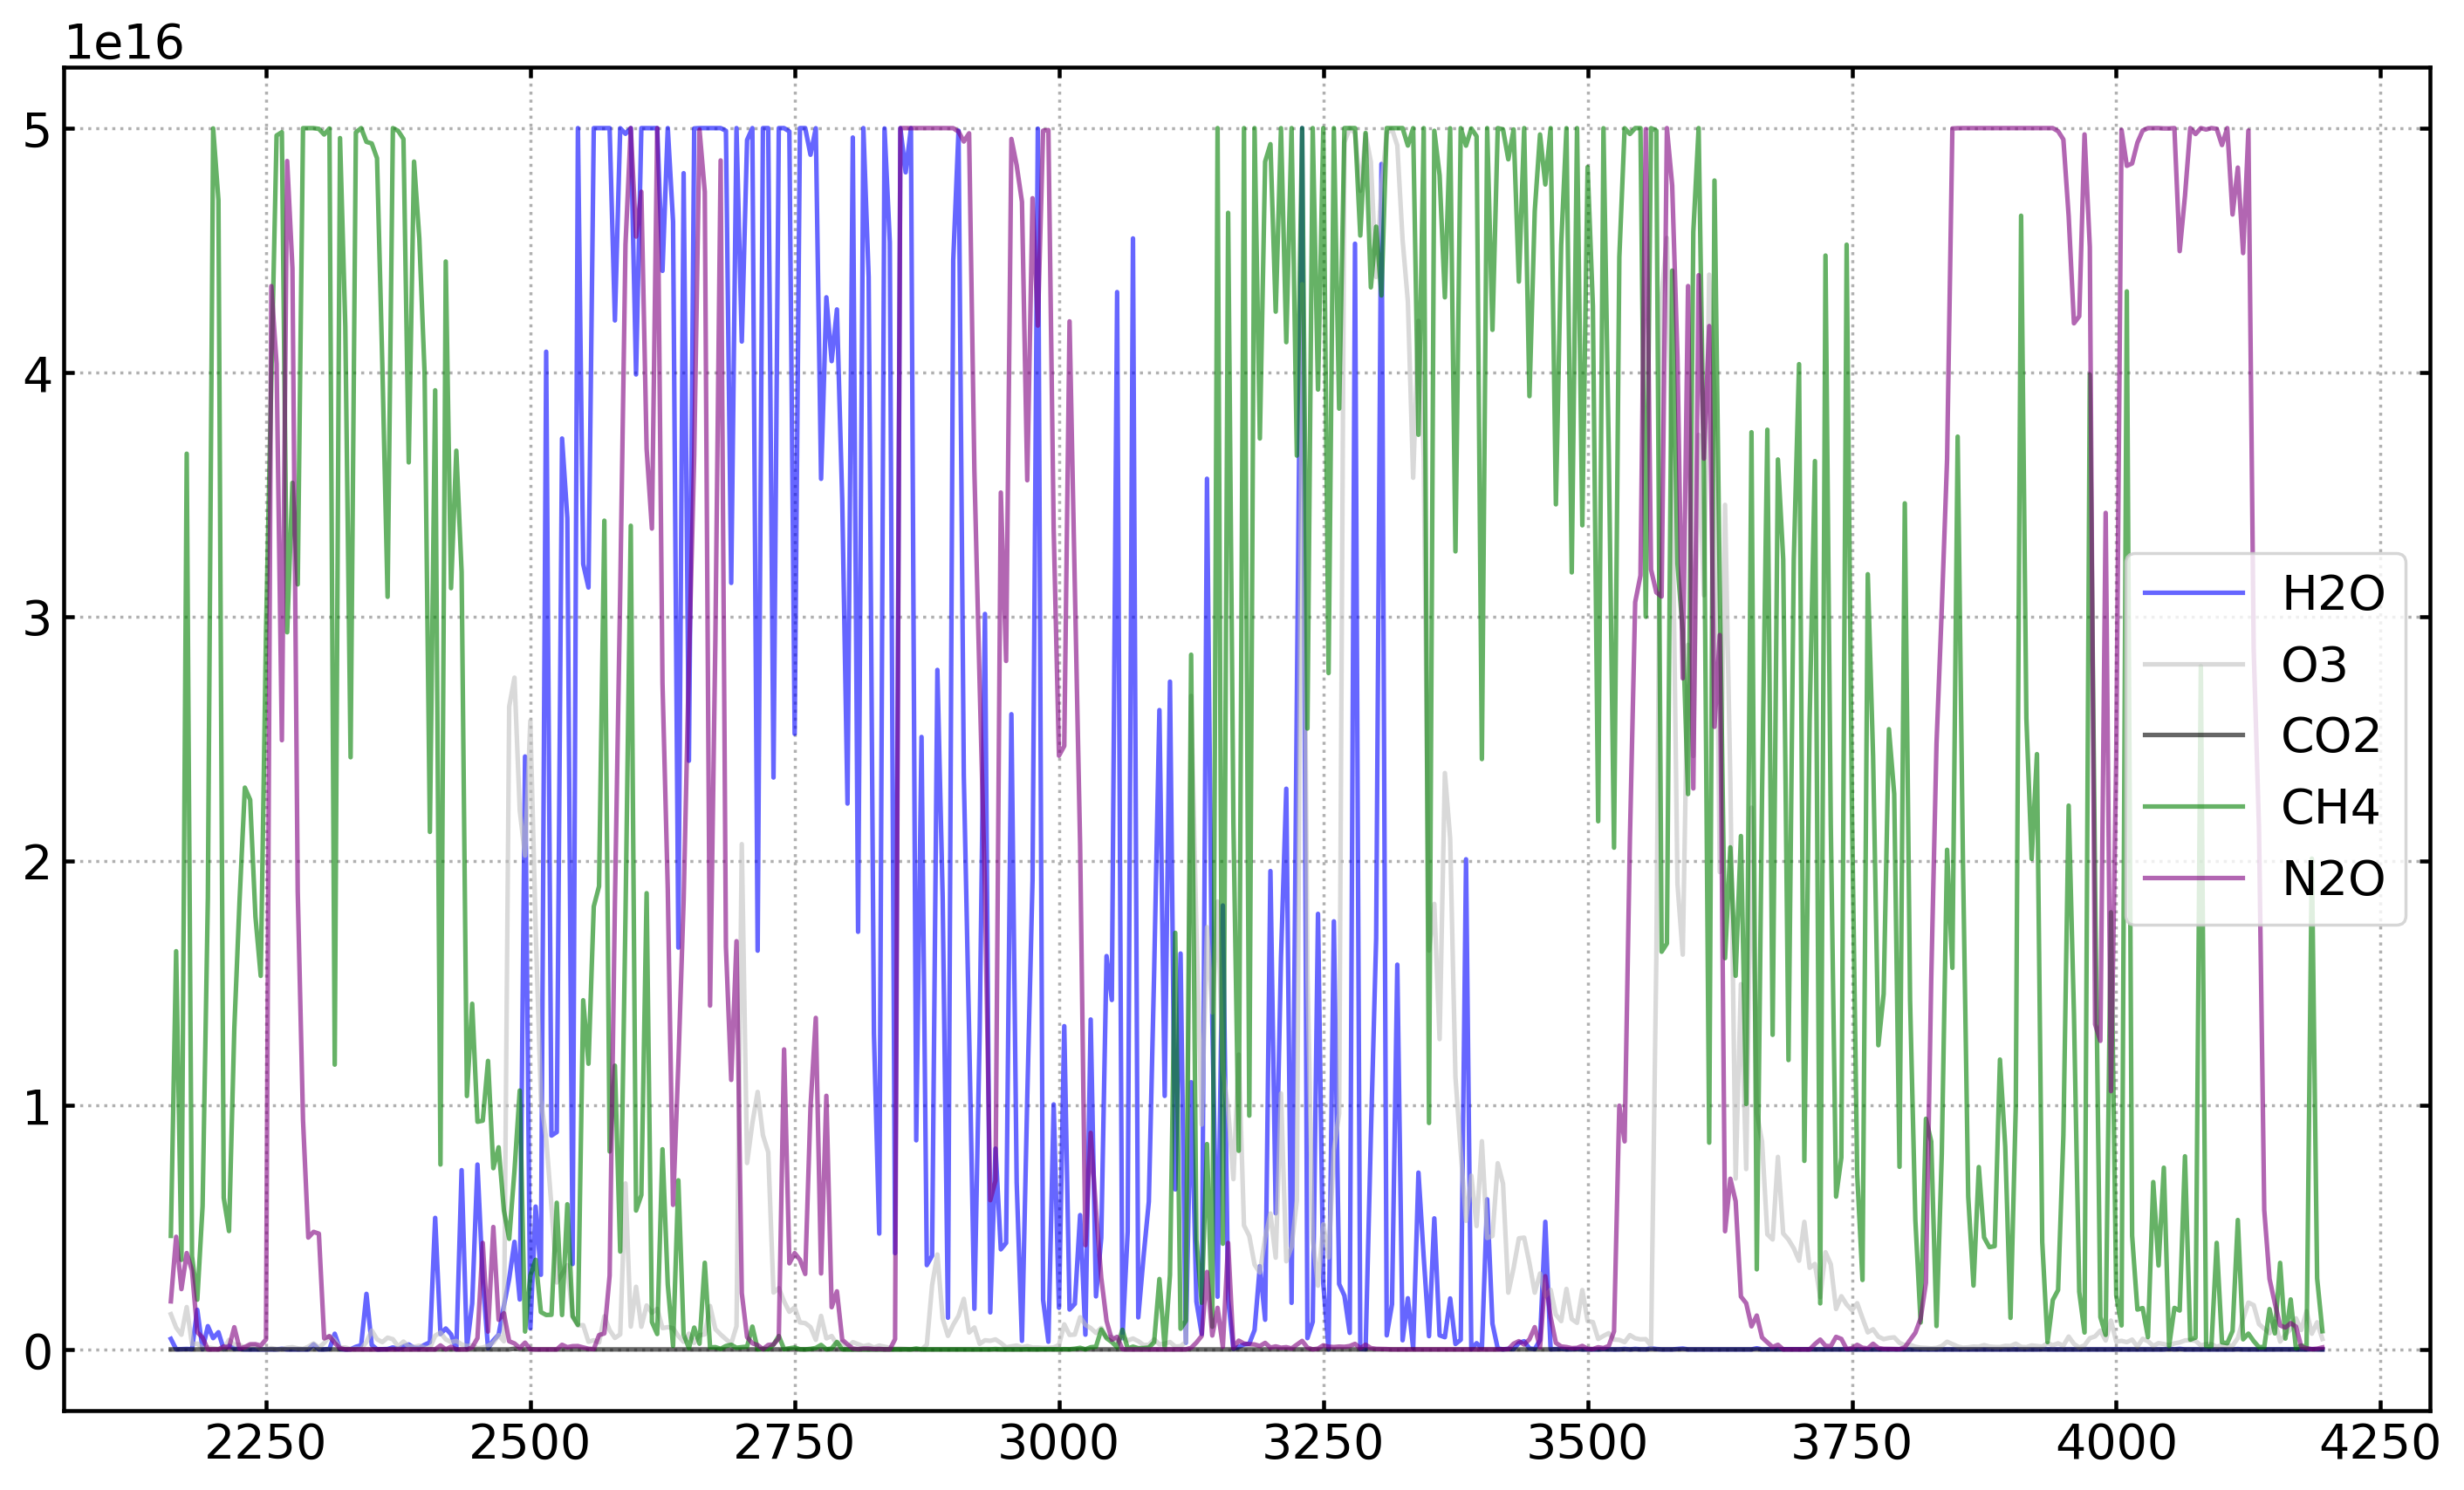

In [168]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False)
#ax.plot(nu_h2o, absorp_h2o, label="H2O", alpha=0.6, color="Blue")
#ax.plot(nu_o3, absorb_o3, label="O3", alpha=0.6, color="silver")
#ax.plot(nu_co2, absorb_co2, label="CO2", alpha=0.6, color="black")
#ax.plot(nu_ch4, absorp_ch4, label="CH4", alpha=0.6, color="green")
#ax.plot(nu_n2o, absorp_n2o, label="N2O", alpha=0.6, color="Purple")

ax.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o * 5e16, label="H2O", alpha=0.6, color="Blue")
ax.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3 * 5e16, label="O3", alpha=0.6, color="silver")
ax.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2 * 5e16, label="CO2", alpha=0.6, color="black")
ax.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4 * 5e16, label="CH4", alpha=0.6, color="green")
ax.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o * 5e16, label="N2O", alpha=0.6, color="Purple")

ax.legend()
plt.show()

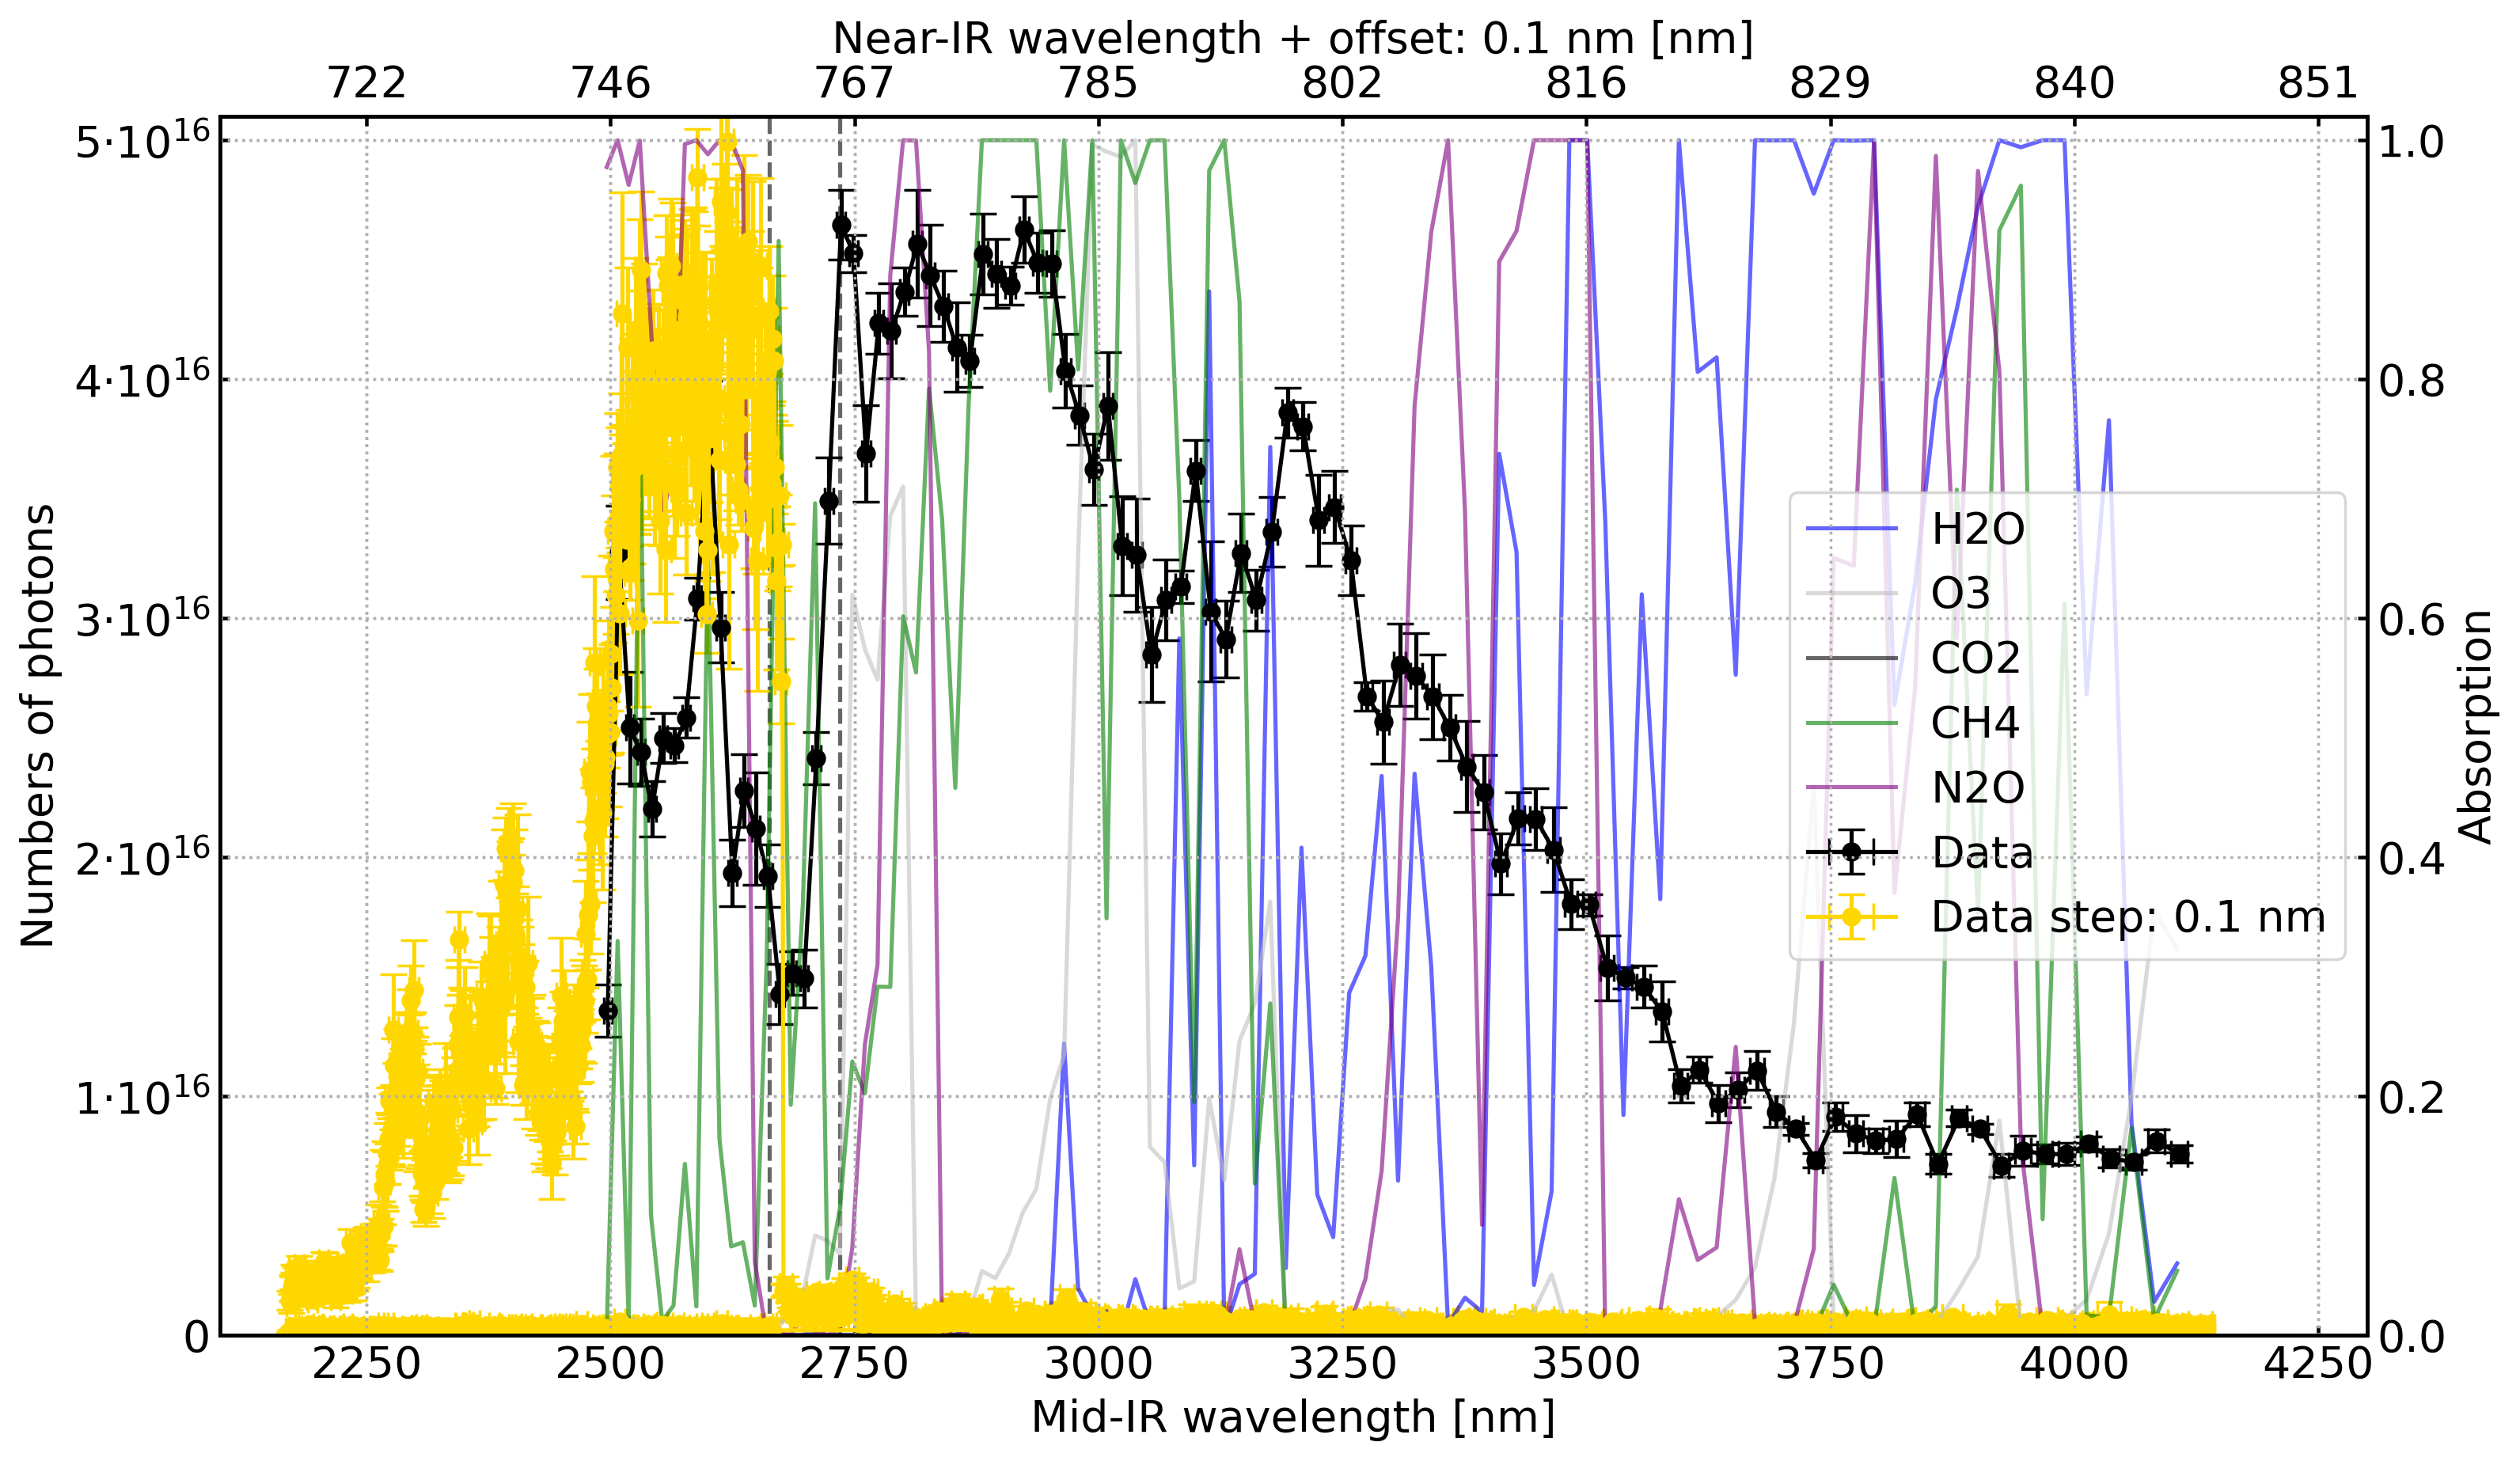

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False)
                        #gridspec_kw={'width_ratios': [1], 'height_ratios': [2/3, 1/3]})
line = True
fill = False
for i in range(len(water_vib_wavelengths)):
    if i == 1:
        continue
    if line:
        ax.axline((water_vib_wavelengths[i], 0), (water_vib_wavelengths[i], 5e16),
              # label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color="black", alpha=0.6, linestyle="--"
                    )
    if fill:
        ax.fill_betweenx([0, 5e16], water_vib_wavelengths[i] - 10, water_vib_wavelengths[i] + 10,
              label=water_vib_naming[i] + f": {round(water_vib_energies[i], 2):.2f} eV", 
                     color=water_colors[i], alpha=0.6
                    )

ax.set_ylabel("Numbers of photons")
ax.set_xlabel("Mid-IR wavelength [nm]")
# ax.set_title("The amount of photons at given wavelengths")


xs = [x.n for x in mean_wavelength_offset]
xs_unc = [x.s for x in mean_wavelength_offset]
ys = [y.n for y in mean_photon]
ys_unc = [y.s for y in mean_photon]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data', color='Black', capsize=5)


ax.set_ylim(0, 5.1e16)
ax.set_xlim(2100, 4300)

xs = [x.n for x in df_0_1_nm_tot["MonWavelengthMidIR_offset"]]
xs_unc = [x.s for x in df_0_1_nm_tot["MonWavelengthMidIR_offset"]]
ys = [y.n for y in df_0_1_nm_tot["N_Photons"]]
ys_unc = [y.s for y in df_0_1_nm_tot["N_Photons"]]

ax.errorbar(xs, ys, yerr=ys_unc, xerr=xs_unc, fmt='o-', label='Data step: 0.1 nm', color='gold', capsize=5)


ax2 = ax.twiny()

ax2.set_xticks(ax.get_xticks()) 
ax2.set_xlim(2100, 4300)
ax2.set_xticklabels([f"{round(mid_ir_to_near_ir(x_tick), 0):.0f}" for x_tick in ax.get_xticks()])
ax2.set_xlabel(f'Near-IR wavelength + offset: {near_ir_offset} nm [nm]', color='Black')
ax2.tick_params(axis='x', labelcolor='Black')

ax2 = ax.twinx()

ax2.set_yticks(ax.get_yticks()) 
ax2.set_ylim(0, 5.1e16)
ax2.set_yticklabels([f"{y_tick:.1f}" for y_tick in np.linspace(0, 1.2, len(ax.get_yticks()))])
ax2.set_ylabel('Absorption', color='Black')
ax2.tick_params(axis='y', labelcolor='Black')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(formatter)
ax.set_yticks(np.arange(0, 6e16, 1e16))
ax.set_yticklabels([f'{int(tick/1e16)}' + r'$\cdot 10^{16}$' if tick!=0 else '0' for tick in ax.get_yticks()])

ax.plot([wavenumber_to_wavelength(w) for w in nu_h2o], absorp_h2o * 5e16, label="H2O", alpha=0.6, color="Blue")
ax.plot([wavenumber_to_wavelength(w) for w in nu_o3], absorb_o3 * 5e16, label="O3", alpha=0.6, color="silver")
ax.plot([wavenumber_to_wavelength(w) for w in nu_co2], absorb_co2 * 5e16, label="CO2", alpha=0.6, color="black")
ax.plot([wavenumber_to_wavelength(w) for w in nu_ch4], absorp_ch4 * 5e16, label="CH4", alpha=0.6, color="green")
ax.plot([wavenumber_to_wavelength(w) for w in nu_n2o], absorp_n2o * 5e16, label="N2O", alpha=0.6, color="Purple")

ax.legend()
plt.show()


### Test to get the correction for the calculation of the mid-IR beam

In [ ]:
# Flash lamp discharges: 010853300

In [ ]:
wavelength_near_ir = [
    746.000, 786.000, 
    
]
wavelength_mid_ir = [
    2493.523, 3004.617, 
]
print(f"Laservision [nm] │ Mine [nm]")
for i in range(len(wavelength_near_ir)):
    print(f"         {wavelength_mid_ir[i]:.3f} │ {wavelength_idler_config(wavelength_near_ir[i]).n:.4f} ")


In [ ]:
wavenumber = wavelength_idler_config(wavelength_near_ir[1]).n
1 / wavenumber * 1e7 